# Активность пользователей в поиске VK Видео 
- Автор: Пулькина Анастасия
- Дата: 02.04.2025

<div class="alert alert-info">

### Цели и задачи проекта
    
    
</div>

**Цель проекта** - анализ данных об активности пользователей в поиске VK Видео. 

**Задачи**:
 1. Знакомство с данными: загрузка, предобработка (обработка типа данных и пропусков)  
 2. Поиск точек роста продукта: в каких случаях поиск показывает плохое качество.
 3. Используя визуализацию показать проблемные случаи  
 4. Краткие выводы 

Датасет `analytics_test.csv` содержит информаию о пользователях и их запросах. В датасете представленны следующие данные: 
- `user_id`	- идентификатор пользователя
- `sex`	- пол пользователя
- `age`	- возраст
- `platform` - платформа	
- `query_id` - идентификатор поиска	
- `query_text` - текст введенного запроса	
- `query_type` - тема запроса  	
- `event` - действие, которое совершает пользователь (`tap`, `like`, `subscribe`, `view`, `share`, `search`)	
- `click_position` - номер позиции, по которой кликает пользователь	
- `doc_type`	- тип документа по которому совершется событие `event`
- `view_time` - время просмотра

Для начала необходимо определить, что будем считать плохим качесвтом поиска. Критерии могут быть следующими: 
- Низкая релевантность выдачи (приходится кликать на более далекие позиции `click_position`, чтобы найти ответ)
- Короткое время просмотра `view_time`, что может говорить о том, что пользователь не вовлекся и быстро ушел со страницы 
- Мало действий `event`, что готовит о низкой вовлеченности пользователя
- Повторные поиски `search` в `event` по похожему запросу


<div class="alert alert-info">
    
### Содержимое проекта
</div>

1. [Загрузка и предобработка данных](#download_data)
2. [Исследовательский анализ данных](#eda)
3. [Итоговый вывод](#summary)
---

<div class="alert alert-info">
    
## Загрузка, знакомство с данных и их предобработка
<a id='download_data'></a>
</div>

In [1]:
# Импортирую необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!pip install phik
from phik import phik_matrix

In [3]:
!pip install matplotlib-venn
from matplotlib_venn import venn3

In [4]:
import requests

In [5]:
# Загружаю датасет

public_key = "https://disk.yandex.ru/d/GruOijWHnJE1og"  

# 1. Запрашиваем у API Яндекс.Диска прямой (download) URL для чтения файла
api_endpoint = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
params = {"public_key": public_key}
response = requests.get(api_endpoint, params=params)
response.raise_for_status()  

download_url = response.json()["href"]
# Теперь download_url — это прямой адрес к самому файлу без CAPTCHA

# 2. Считываем CSV напрямую из полученного download_url
df = pd.read_csv(download_url)

df.head()

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        15042 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


In [7]:
# ищу пропуски 
df_missing = df.copy() # Буду работать с копием        
missing = pd.DataFrame({
    'Кол-во пропусков': df_missing.isnull().sum(), 
    'Доля пропусков': df_missing.isnull().mean().round(4)})
           
missing.sort_values(by='Кол-во пропусков', ascending=False).style.background_gradient(cmap='coolwarm')

,Кол-во пропусков,Доля пропусков
doc_type,4958,0.247900
Unnamed: 0,0,0.000000
user_id,0,0.000000
sex,0,0.000000
age,0,0.000000
platform,0,0.000000
query_id,0,0.000000
query_text,0,0.000000
query_type,0,0.000000
event,0,0.000000


In [8]:
# Типы данных соответствуют, проверим, можно ли снизить их разрядность
for column in ['user_id', 'age', 'query_id', 'click_position', 'view_time']:
    df[column] = pd.to_numeric(df[column], downcast='integer')    
    print(f'Тип данных столбца {column} после преобразования:', df[column].dtype)

Тип данных столбца user_id после преобразования: int32
Тип данных столбца age после преобразования: int8
Тип данных столбца query_id после преобразования: int32
Тип данных столбца click_position после преобразования: int8
Тип данных столбца view_time после преобразования: int16


In [9]:
# Посмотрим на уникальные значения и их число 
for column in df.columns:
    print(f'Число уникальных значений в столбце {column}:')
    print(df[column].sort_values().nunique())
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Число уникальных значений в столбце Unnamed: 0:
20000
Уникальные значения в столбце Unnamed: 0:
[    0     1     2 ... 19997 19998 19999]

Число уникальных значений в столбце user_id:
16292
Уникальные значения в столбце user_id:
[    1273    10462    16177 ... 99994451 99994735 99995697]

Число уникальных значений в столбце sex:
3
Уникальные значения в столбце sex:
['anonym' 'female' 'male']

Число уникальных значений в столбце age:
61
Уникальные значения в столбце age:
[ 0 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63 64 65 66 67 68 69]

Число уникальных значений в столбце platform:
5
Уникальные значения в столбце platform:
['android' 'android_tv' 'iphone' 'smart_tv' 'web']

Число уникальных значений в столбце query_id:
18430
Уникальные значения в столбце query_id:
[     8758     11466     17851 ... 999480472 999637926 999861194]

Число уникальных значений в столбце qu

In [10]:
# посмотрим на пользователей, у которых возраст стоит 0. 
df[df['age']==0]

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
5,5,8004249,anonym,0,android,19760211,как купить билеты на Грибов,music,tap,1,author,0
7,7,79473329,anonym,0,smart_tv,569617620,биография Мэрилин Монро,films,tap,5,clip,0
8,8,17370723,anonym,0,android,46720550,поездка или поездочка шоу истории,show,subscribe,9,video,0
15,15,78248209,anonym,0,smart_tv,877568600,русские фильмы про войну,films,tap,1,video,0
18,18,27726347,anonym,0,smart_tv,756294021,российские премии за лучший сценарий,films,search,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19977,19977,10064610,anonym,0,web,26541601,юридические технологии новости,news,tap,10,author,0
19985,19985,77464757,anonym,0,android_tv,155502390,где снимался Том Круз в 2024,films,view,0,clip,2983
19993,19993,35306851,anonym,0,android_tv,98198219,большое шоу с,show,tap,6,author,0
19995,19995,96140045,anonym,0,web,41018546,мем с грустным скрипачом,music,search,0,NaN,0


In [11]:
# Посмотрим на распределение значений с возрастом 0 по признаку пола
df[df['age']==0]['sex'].value_counts()

sex
anonym    4479
female     172
male        82
Name: count, dtype: int64

In [12]:
# Посмотрим на пользователей, у которых в столбце `doc_type` нет данных
df[df['doc_type'].isna()]

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
10,10,25020295,female,41,iphone,14517548,где смотреть редкое артхаусное кино,films,search,0,NaN,0
17,17,42057324,male,29,iphone,17870585,утреннее шоу 2 сезон 3 серия,show,search,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19992,19992,86799932,male,30,iphone,95842645,политическое прогнозирование новости,news,search,0,NaN,0
19995,19995,96140045,anonym,0,web,41018546,мем с грустным скрипачом,music,search,0,NaN,0
19997,19997,83070163,anonym,0,iphone,68120968,допрос шоу нурлан,show,search,0,NaN,0
19998,19998,23171813,female,23,android_tv,28022664,кстати шоу жу,show,search,0,NaN,0


In [13]:
# Посмотрим на распределение значений столбца 'click_position' в запросах, где нет данных в столбце 'doc_type'
df[df['doc_type'].isna()]['click_position'].value_counts()

click_position
0    4958
Name: count, dtype: int64

In [14]:
# Посмотрим, какие действия производят пользователи6 если в 'doc_type' нет данных
df[df['doc_type'].isna()]['event'].value_counts()

event
search    4958
Name: count, dtype: int64

In [15]:
# Посмотрим на распределение значений столбц view_time' в запросах, где нет данных в столбце 'doc_type'
df[df['doc_type'].isna()]['view_time'].value_counts()

view_time
0    4958
Name: count, dtype: int64

In [16]:
# и тоже самое сделаем для типа запросов
df[df['doc_type'].isna()]['query_type'].value_counts()

query_type
films    1258
show     1241
news     1232
music    1227
Name: count, dtype: int64

In [17]:
# и платформы
df[df['doc_type'].isna()]['platform'].value_counts()

platform
android       1065
smart_tv      1062
iphone        1047
android_tv     997
web            787
Name: count, dtype: int64

In [18]:
df[df['view_time']==0]['event'].value_counts()

event
tap          6564
search       4958
like         2195
subscribe    2142
share        1224
Name: count, dtype: int64

In [19]:
df[df['click_position']==0]['event'].value_counts()

event
search       4958
tap           174
view           48
share          36
like           32
subscribe      31
Name: count, dtype: int64

Если в столбце `doc_type` нет данных, то пользователи осуществляют только поиск. И в столбцах `click_position` и `view_time` данные равны нулю. Значение 0 в столбце `click_position` видимо является заглушкой, согнализирующей об отсутствии последующего действия, так как в описании задания сказано, что первый элемент выдачи - 1. Однако значение 0 в столбцах `click_position` и `view_time` встречается не только для поиска но и для других действий. 

In [20]:
df.head()

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0


In [21]:
# Проверяю наличие полных явных дубликатов в датафрейме 
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


### Промежуточный вывод 

Предварительное знакомство с датасетом `analytics_test.csv` показало, что датасет содержит 20000 строк и 12 столбцев. Названия столбцев корректные, соответствуют информации, содержащейся в ней. В столбце `doc_type` содержится 4958 пропусков, что составляет 25% от общего числа сторок. Это пользователи, которые осуществляли только поиск. Для них значени в столбцах `click_position` и `view_time` равны 0. Распределение по теме запросов и по используемой платформе примерно равномерное.   
В столбце `age`, возраст встречается 0, что может быть заглушкой, если пользователь, например, не указал свой возраст (но мне кажется, что при регистрации в ВК, указание возраста обязательно) Следующая цифра по возрастанию в столбце возраст - 10. Пол у пользователей с возрастом 0 по большей части оставлен анонимным, но встречаются как мужчины, так и женщины. Возможно, есть какая-то опция о приватности личных данных. Эти данные требуют уточнения.  
При предварительном просмотре также понизила размерность целочисленных данных, явных полных дубликатов не обнаружила. 


<div class="alert alert-info">
    
## Исследовательский анализ данных
<a id='eda'></a>
</div>

In [22]:
df.head()

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0


<div style="background-color:lightblue;">
    
### Распределение событий 

</div>

In [23]:
# Посмотрим на распределение событий 'event' в нашем датасете 
pd.DataFrame({
     'Кол-во событий': df['event'].value_counts(), 
    'Доля событий': df['event'].value_counts(normalize=True).round(2)})


,Кол-во событий,Доля событий
event,,
tap,6564,0.33
search,4958,0.25
view,2917,0.15
like,2195,0.11
subscribe,2142,0.11
share,1224,0.06


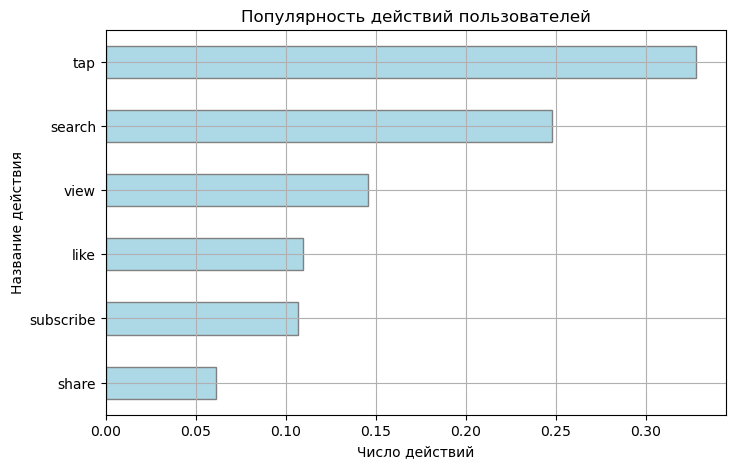

In [24]:
# визуализируем его в долях
grouped_event = df['event'].value_counts(normalize=True).sort_values(ascending = True)

grouped_event.plot(kind='barh',
                   title='Популярность действий пользователей',
                   legend=False,
                   ylabel='Название действия',
                   xlabel='Число действий',
                   edgecolor='grey',
                   rot=0,
                   figsize=(8, 5),
                   color='lightblue')

plt.grid()
plt.show()

Больше всего пользователи кликают (33%) и что-то ищут (25%). 

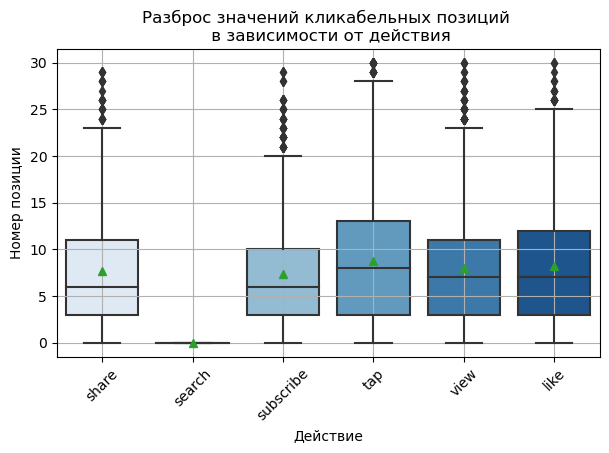

In [25]:
# Посмотрим на разброс значений в столбце 'click_position' в зависимости от происходящего события
plt.figure(figsize=(7, 4))
sns.boxplot(x= 'event', 
            y='click_position', 
            data=df,
            palette='Blues', 
            showmeans=True  
            ).set(title = 'Разброс значений кликабельных позиций \n в зависимости от действия', 
                             xlabel = 'Действие', 
                             ylabel = 'Номер позиции'
                             )   

plt.xticks(rotation=45)
plt.grid()
plt.show()

Наименьшая позиция в выдаче поиска для поиска. Это мы уже знает, что оно равно 0. Остальные распределены относительно равномерно.

<div style="background-color:lightblue;">
    
### Распределение позиции документа в выдаче поиска по которму совершено событие и времени просмотра

</div>

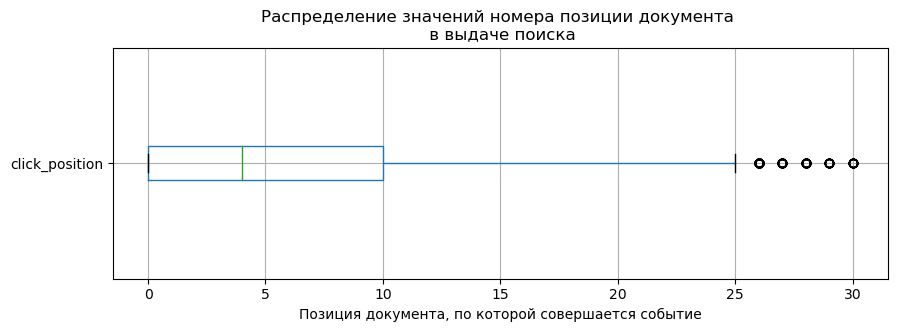

In [26]:
# Построим диаграмму размаха для столбца 'click_position'
plt.figure(figsize = (10, 3))
df.boxplot(column = 'click_position', vert = False, showfliers=True)
plt.title('Распределение значений номера позиции документа \n в выдаче поиска')
plt.xlabel('Позиция документа, по которой совершается событие')


plt.show()

Есть выбросы, но я бы не стала их исключать из анализа, они не выглядят на мой взгляд подозрительно.

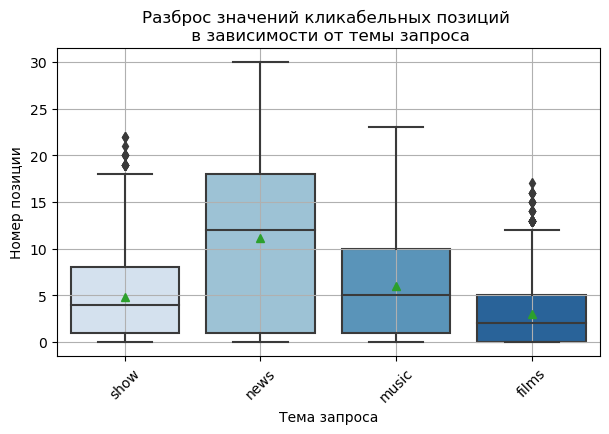

In [27]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='query_type', 
            y='click_position', 
            data=df,
            palette='Blues',
            showmeans=True  
            ).set(title = 'Разброс значений кликабельных позиций \n в зависимости от темы запроса', 
                             xlabel = 'Тема запроса', 
                             ylabel = 'Номер позиции'
                             )   

plt.xticks(rotation=45)
plt.grid()
plt.show()

Самый большой разброс позиции документа в выдаче поиска для новостных запросов. Для них же отмечено самое больше значение и самые высокие среднее и медиана. То есть при чтении новостей люди часто открывают не первую позицию в выдаче. Это может говорить о том, что им не нравится то, что предлатается в начале.

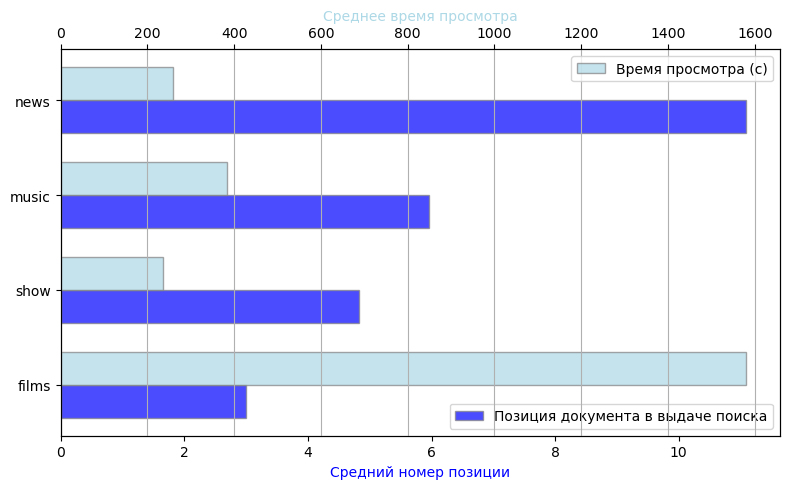

In [28]:
# Посмотрим на средние значения 'click_position' и 'view_time' при разбивке по темам запроса 'query_type'

grouped_type = df.groupby('query_type').agg({
    'click_position': 'mean', 
    'view_time': 'mean'
}).sort_values('click_position', ascending=True)
# Построим столбчатые диаграммы на двух осях
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twiny()  

bar_width = 0.35
index = np.arange(len(grouped_type.index))

# Номер позиции по которой кликает пользователь
ax1.barh(index - bar_width/2, grouped_type['click_position'],
         height=bar_width, color='blue', alpha=0.7, label='Позиция документа в выдаче поиска', edgecolor='grey')
ax1.set_xlabel('Средний номер позиции', color='blue')

# Время просмотра
ax2.barh(index + bar_width/2, grouped_type['view_time'],
         height=bar_width, color='lightblue', alpha=0.7, label='Время просмотра (с)', edgecolor='grey')
ax2.set_xlabel('Среднее время просмотра', color='lightblue')

# Общие настройки
ax1.set_yticks(index)
ax1.set_yticklabels(grouped_type.index)
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
plt.grid()

plt.tight_layout()

In [29]:
pd.pivot_table(df,
                index='query_type',
                values=['view_time', 'click_position'],
                aggfunc=['mean', 'max', 'count'])

mean                       max                    count  \
           click_position  view_time click_position view_time click_position   
query_type                                                                     
films              3.0020  1579.1048             17     17994           5000   
music              5.9528   383.7088             23     10765           5000   
news              11.0828   259.7342             30      7140           5000   
show               4.8270   236.5540             22      7119           5000   

                      
           view_time  
query_type            
films           5000  
music           5000  
news            5000  
show            5000

Ожидаемо, самое большое среднее время просмотра  и максимальное значение у фильмов. Средняя и максимальная наибольшая позиция документа, по которой кликают, - у новостей. При этом и время просмотра для новостной тематики не высокое.  Здесь нужно отметить, что число наблюдений по группам query_type одинаковое. 

Посмотрим, есть ли какая-то зависимость типа документа, кликабельной позиции и временем просмотра с другими данными.

interval columns not set, guessing: ['Unnamed: 0', 'user_id', 'age', 'query_id', 'click_position', 'view_time']


/Users/a1234/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable query_text is large: 1891. Are you sure this is not an interval variable? Analysis for pairs of variables including query_text can be slow.
  warnings.warn(


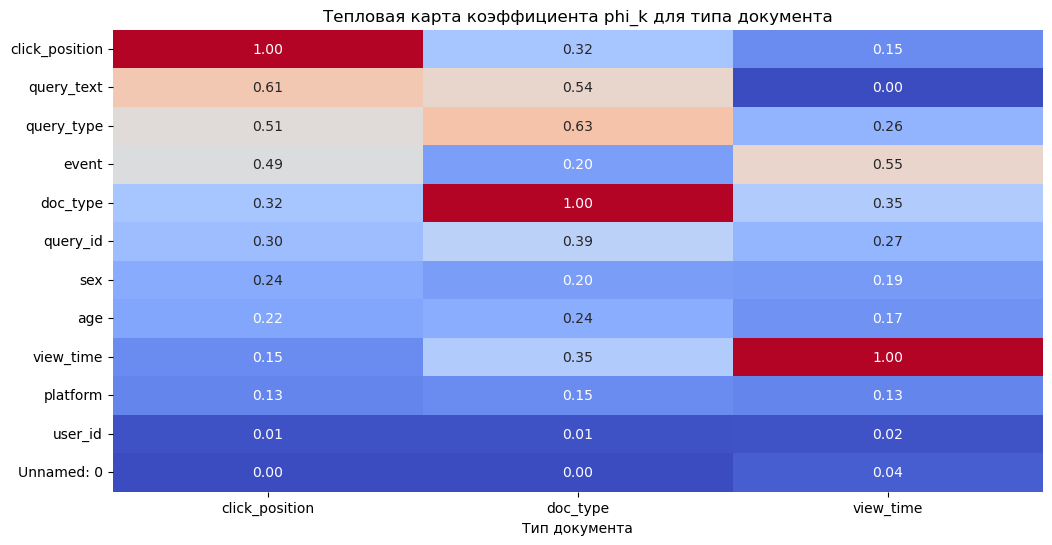

In [30]:
# Построим корреляционную матрицу
cor_matrix = df.phik_matrix()
plt.figure(figsize=(12,6))
data_heatmap = cor_matrix[['click_position', 'doc_type', 'view_time']].sort_values(by='click_position', ascending=False)
sns.heatmap(data_heatmap,
           annot = True, 
           fmt='.2f', 
           cmap = 'coolwarm',
           cbar = False
           )

plt.title('Тепловая карта коэффициента phi_k для типа документа')
plt.xlabel('Тип документа')

plt.show()

Есть умеренная положительная корреляция позиции документа в поиске с темой, текстом запроса и действием; типа документа с темой запроса и текстом запроса; и времени просмотра с событием.  

Тему с наибольшим средним числом позиции документа в поиске мы уже определели (новости). Теперь посмотрим на текст запросов и действия в запросах с далекой кликабельной позицией. Также посмотрим на другие выявленные корреляции. 

<div style="background-color:lightblue;">
    
### Выявление проблемных запросов. Гипотезы.

</div>



**1. Если пользователь совершает действие по позиции документа в выдаче поиска больше среднего значения, то выдача нерелевантна.**  

In [31]:
# Найдем среднее значение позиции документа в выдаче поиска, по которому совершается действие
df['click_position'].mean().round(2)

6.22

Среднее значение для числа кликов - 6. Будем считать это пороговым значением. Отфильтруем наш датасет по этой границе и выведем только топ-10. Я хочу сразу посмотреть на время посмотра. Если оно маленькое - значит человеку было не интересно и он не перешел ни на одну страницу поиска, поиск был нерелевантен. 

In [32]:
bad_clicks = df[df['click_position'] > 6].groupby('query_text').agg({
    'click_position': 'mean', 
    'view_time': 'mean'
}).sort_values('click_position', ascending=False).head(10)
bad_clicks

,click_position,view_time
query_text,,
образование за рубежом новости,27.500000,382.000000
бренд-маркетинг новости,24.666667,0.000000
газеты новости,24.000000,0.000000
страхование новости,23.333333,0.000000
IT-услуги законодательство,23.000000,1115.000000
музыкальные технологии новости,22.800000,897.200000
тренинговое законодательство,22.666667,739.333333
строительное законодательство,22.600000,396.400000
обучение персонала новости,22.500000,3438.000000


Все запросы связаны с новостной тематикой.  
Дополнительно отфильтрую датасет, оставив в нем те запросы, в которых время просмотра равно 0. Большое число кликов и нулевое время просмотра могут значить нерелевантную выдачу. 

**2. Если время просмотра равно нулю и кликабельная позиция выше средней - поиск по запросу не релевантен**

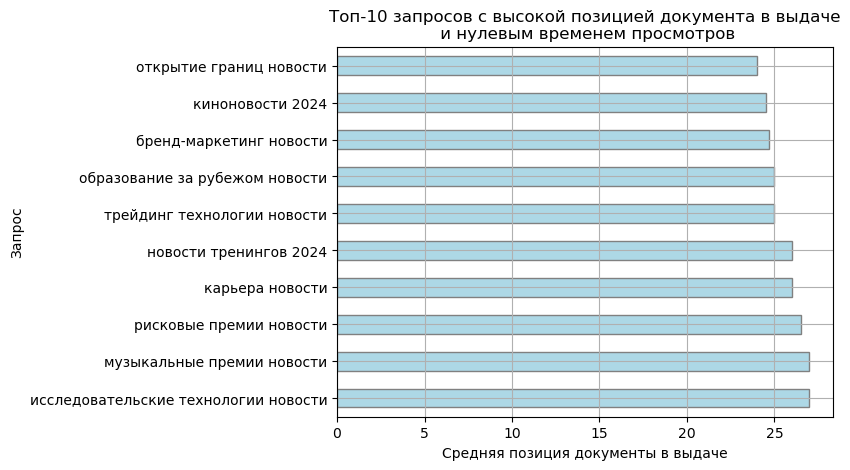

In [33]:
bad_clicks_views = df[
    (df['click_position'] > 6)&
    (df['view_time'] ==0)
].groupby('query_text')['click_position'].mean().sort_values(ascending=False).head(10)

bad_clicks_views.plot(kind='barh', 
                        title='Топ-10 запросов с высокой позицией документа в выдаче\n и нулевым временем просмотров', 
                        color='lightblue', 
                        edgecolor='grey')

plt.xlabel('Средняя позиция документы в выдаче')
plt.ylabel('Запрос')
plt.grid()
plt.show()

Также все запросы остались с новостной тематикой.  Продолжим изучение коротких просмотров. 

**3. Если время просмотра короткое (равно 0), то результаты поиска скорее всего не заинтересовали**

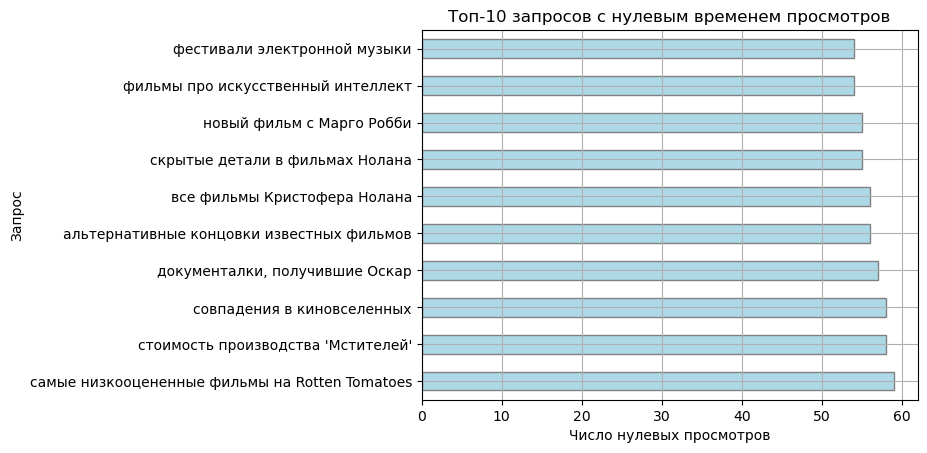

In [34]:
bad_views_text = df[df['view_time'] ==0].groupby('query_text')['view_time'].count().sort_values(ascending=False).head(10)

bad_views_text.plot(kind='barh', 
                        title='Топ-10 запросов с нулевым временем просмотров', 
                        color='lightblue', 
                        edgecolor='grey')
plt.xlabel('Число нулевых просмотров')
plt.ylabel('Запрос')
plt.grid()
plt.show()

Наибольшее число запросов, в которых время просмотра равно 0, связано с фильмами. 

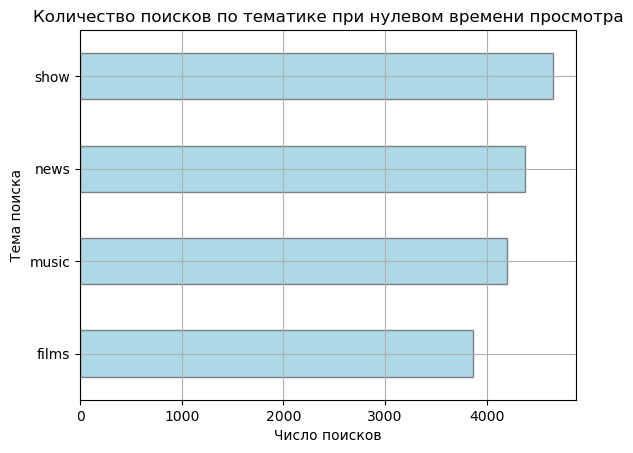

In [35]:
# посмотрим, какие темы для поиска приводят к нулевым просмотрам
bad_views_type = df[df['view_time'] ==0]['query_type'].value_counts().sort_values(ascending = True)

bad_views_type.plot(kind='barh',
                   title='Количество поисков по тематике при нулевом времени просмотра',
                   legend=False,
                   ylabel='Тема поиска',
                   xlabel='Число поисков',
                   edgecolor='grey',
                   color='lightblue')

plt.grid()
plt.show()

Но если смотреть темы отдельно, кажется, что нет лидеров и аутсайдеров.

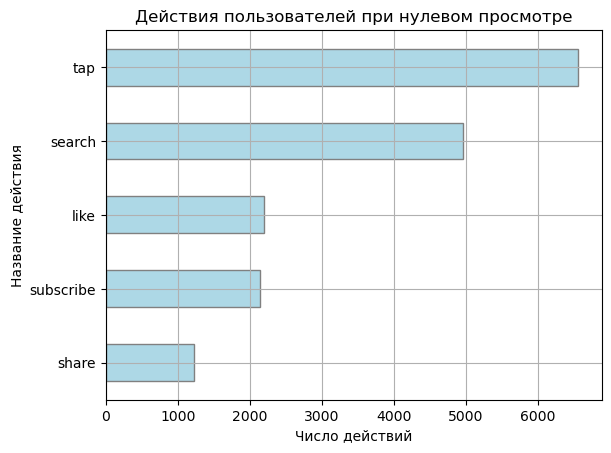

In [36]:
# посмотрим, какие события сопровождаются нулевыми просмотрами
bad_views_event = df[df['view_time'] ==0]['event'].value_counts().sort_values(ascending = True)

bad_views_event.plot(kind='barh',
                   title='Действия пользователей при нулевом просмотре',
                   legend=False,
                   ylabel='Название действия',
                   xlabel='Число действий',
                   edgecolor='grey',
                   color='lightblue')

plt.grid()
plt.show()

Нулевые просмотры даже приводят к тому, что пользователи лайкают, подписываются и делятся найденным контентом (это было замечено и выше). Однако наиболее популярное действие, не сопровождающееся просмотром, - просто кликанье и поиск. 

In [37]:
# Посмотрим, как действия с нулевым времением распределены по темам
pd.pivot_table(df[df['view_time'] ==0],
                        values='query_id', 
                        index='query_type', 
                        columns='event', 
                        aggfunc='nunique')

event,like,search,share,subscribe,tap
query_type,,,,,
films,387,1258,392,390,1440
music,776,1227,185,592,1417
news,462,1232,270,239,2169
show,570,1241,377,921,1538


Чаще всего днействия с нулевым временем встречаются при кликании по теме новости. Дальше шшоу, фильмы и музыка. Меньше всего нулевых просмотров при шеринге музыкой и подпиской на новости.

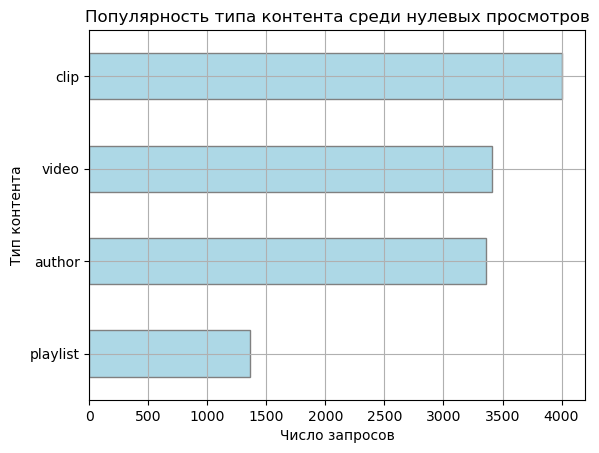

In [38]:
# тогда еще посмотрим, в каком типе контента больше всего встречаются нулевые просмотры
bad_views_doc = df[df['view_time'] ==0]['doc_type'].value_counts().sort_values(ascending = True)

bad_views_doc.plot(kind='barh',
                   title='Популярность типа контента среди нулевых просмотров',
                   legend=False,
                   ylabel='Тип контента',
                   xlabel='Число запросов',
                   edgecolor='grey',
                   color='lightblue')

plt.grid()
plt.show()

Наиболее характерно нулевое время просмотра для клипов. Наименее характерно - для плейлистов.

**4. Если мало лайков и шерингов, то результаты поиска не вызывают интерес и вовлеченность**

In [39]:
# Посмотрим на топ-10 запросов с низкой вовлеченностью
low_intrest = df[df['event'].isin(['like', 'share'])]['query_text'].value_counts()
print('\nТоп-10 запросов с низкой вовлечённостью:\n', low_intrest.tail(10))


Топ-10 запросов с низкой вовлечённостью:
 query_text
большое шоу га                  1
большое шоу 4 сезон             1
абу шоу нидаль про эпилепсию    1
я тне верю шоу тнт              1
банковские новости              1
боьшое шоу 11сезон              1
большое шоу 11 сезон 3 серия    1
технологические прорывы         1
археологические открытия        1
большое шоу 11 5                1
Name: count, dtype: int64


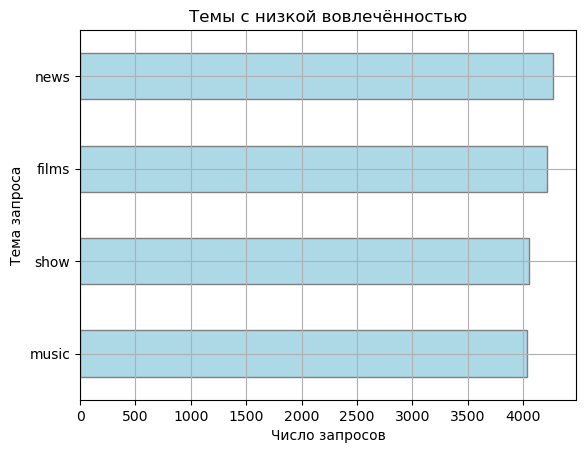

In [40]:
# Посмотрим, какая тема вывывает наименьшую вовлеченность
low_intrest_type = df[~df['event'].isin(['like', 'share'])]['query_type'].value_counts().sort_values(ascending = True)

low_intrest_type.plot(kind='barh',
                   title='Темы с низкой вовлечённостью',
                   legend=False,
                   ylabel='Тема запроса',
                   xlabel='Число запросов',
                   edgecolor='grey',
                   color='lightblue')

plt.grid()
plt.show()

Темы с низкой вовлеченностью - новости и фильмы. Им меньше всего ставят лайков и реже делятся. 

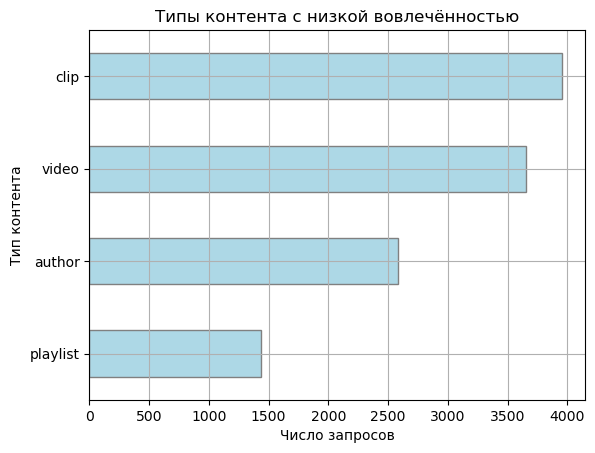

In [41]:
# И какой тип контента менее интересен
low_intrest_doc = df[~df['event'].isin(['like', 'share'])]['doc_type'].value_counts().sort_values(ascending = True)

low_intrest_doc.plot(kind='barh',
                   title='Типы контента с низкой вовлечённостью',
                   legend=False,
                   ylabel='Тип контента',
                   xlabel='Число запросов',
                   edgecolor='grey',
                   color='lightblue')

plt.grid()
plt.show()

Клипы и видео вызывают меньше всего интереса, им реже ставят лайки и ими реже деляться с друзьями.

**5. Пересечение поисковых текстов**

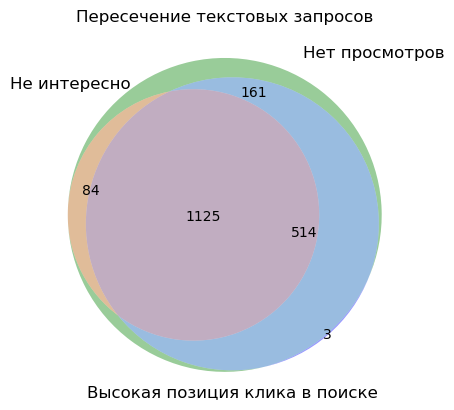

In [42]:
# Построим диаграмму Венна
set_intrest = set(df[df['event'].isin(['like', 'share'])]['query_text'])
set_view = set(df[df['view_time'] ==0]['query_text'])
set_click = set(df[df['click_position'] > 6]['query_text'])

venn3([set_intrest, set_view, set_click], set_labels=('Не интересно', 'Нет просмотров', 'Высокая позиция клика в поиске'))


plt.title('Пересечение текстовых запросов')
plt.show()

1125 запросов попадают во все использованные фильтрации. То есть у 1125 запросов из 20000 нулевое время просмотра, номер позиции клика больше 6 и их не лайкают и ими не делятся пользователи. Это что-то около 5%. Не уверена, что это критично. 


### Промежуточный вывод

В результате исследовательского анализа посмотрела на распределение числовых данных, построила их боксплоты. Посмотрела на корреляцию некоторых признаков, которые на мой взгляд могли бы говорить о релевантности контента в поиске. Были выдвинуты следующие гипотезы: 
1. Если пользователь совершает действие по позиции документа в выдаче поиска больше среднего значения, то выдача не релевантна  
2. Если время просмотра равно нулю и кликабельная позиция выше средней - поиск по запросу не релевантен  
3. Если время просмотра короткое (равно 0), то результаты поиска скорее всего не заинтересовали  
4. Если мало лайков и шерингов, то результаты поиска не вызывают интерес и вовлеченность  

Для проверки гипотез были посчитаны и визуализированы число значений, среднее при разбивке на различные группы. 

Наибольшая позиция документа в выдаче поиска оказалась характерна для новостных поисков. Наибольшее число запросов, в которых время просмотра равно 0, было связано с фильмами. Но если смотреть наибольшую позицию документа в выдаче поиска и нулевое время просмотра, то нерелевантными остаются новостные запросы. Ими меньше делятся, им меньше ставят лайков (отсутствие лайков конечно может быть связано с тем, что новость в негативном ключе, а не потому что она неинтересная). 

<div class="alert alert-info">
    
## Итоговый вывод
<a id='summary'></a>
</div>

- Поиск показывает плохое качесвто в случае новостных запросов. 
- Пользователи открывают в среднем 11 позицию документа в выдаче поиска. Возможно, проблема в алгоритме ранжирования например.
- Пользователи быстро покидают платформу, может быть низкое качество контента по темам шоу и новостей (по этим темам наиболее часто встречается время просмотра равное 0). 
- Низкая вовлеченность пользователей при поиске новостей и фильмов. Им редко ставят лайки и редко делятся с друзбями. Тоже касается клипов и видео. 


Что делать дальше?
- A/B-тестирование новых алгоритмов ранжирования для новостных запросов.
- Опрос пользователей, чтобы понять, почему они не вовлекаются.


PS буду благодарна за обратную связь